In [75]:
from collections import deque
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go



In [76]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [77]:
class Environment:
 
  def __init__(self, data, window_size=90, initial_balance=10000):
    self.data = data
    self.window_size = window_size
    self.initial_balance = initial_balance
    self.reset()

  def reset(self):
    self.balance = self.initial_balance
    self.shares_held = 0
    self.cost_price = 0  # Track buying price for calculating ROI
    self.state = deque(maxlen=self.window_size)
    self.history = self.data.iloc[:self.window_size]  # Initial window of data
    self.current_step = self.window_size  # Start after initial window

    # Fill initial state with normalized prices
    for i in range(self.window_size):
      close_price = self.history.iloc[i]['Close']
      self.state.append((close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])

    return self._get_obs()

  def _get_obs(self):
    return np.array(self.state)

  def step(self, action):
    # Handle actions (0: hold, 1: buy, 2: sell)
    if action == 0:
      pass  # Hold
    elif action == 1:
      if self.balance >= self.data.iloc[self.current_step]['Close'] and self.shares_held == 0:
        self.balance -= self.data.iloc[self.current_step]['Close']
        self.shares_held = 1
        self.cost_price = self.data.iloc[self.current_step]['Close']  # Update cost price
    elif action == 2:
      if self.shares_held > 0:
        self.balance += self.shares_held * self.data.iloc[self.current_step]['Close']
        self.shares_held = 0
        self.cost_price = 0  # Reset cost price after selling

    # Update state and reward
    next_close_price = self.data.iloc[self.current_step]['Close']
    reward = 0
    if self.shares_held > 0:
      reward = (next_close_price - self.cost_price) / self.cost_price  # Calculate ROI as reward
    self.state.append((next_close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])  # Update state
    self.history = pd.concat([self.history, self.data.iloc[self.current_step].to_frame().T])
    self.current_step += 1

    done = self.current_step >= len(self.data)
    return self._get_obs(), reward, done

In [78]:
class QLearningAgent:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q_table = {}
        self.actions = actions
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.losses = []  # List to store loss per episode

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            if tuple(state) not in self.q_table:
                self.q_table[tuple(state)] = np.zeros(len(self.actions))
            action = self.actions[np.argmax(self.q_table[tuple(state)])]
        return action

    def update_q_table(self, state, action, reward, next_state):
        state_str = self.state_to_string(state)
        next_state_str = self.state_to_string(next_state)
    
        # Ensure both state and next_state are in the same format
        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(len(self.actions))
        if next_state_str not in self.q_table:
            self.q_table[next_state_str] = np.zeros(len(self.actions))
    
        # Q-value update
        current_q_value = self.q_table[state_str][action]
        next_max_q_value = np.max(self.q_table[next_state_str])
        target_q_value = reward + self.gamma * next_max_q_value
        loss = 0.5 * (target_q_value - current_q_value)**2  # Compute loss
        self.losses.append(loss)  # Append loss to list
    
        # Update Q-value
        self.q_table[state_str][action] += self.alpha * (target_q_value - current_q_value)


    
    def state_to_string(self, state):
        return ','.join(map(str, state))

In [79]:
ticker_symbol = 'AAPL'
data = download_data(ticker_symbol, "2010-01-01", "2023-12-31")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470740,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378826,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367034,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800


In [80]:
df = pd.DataFrame(data)

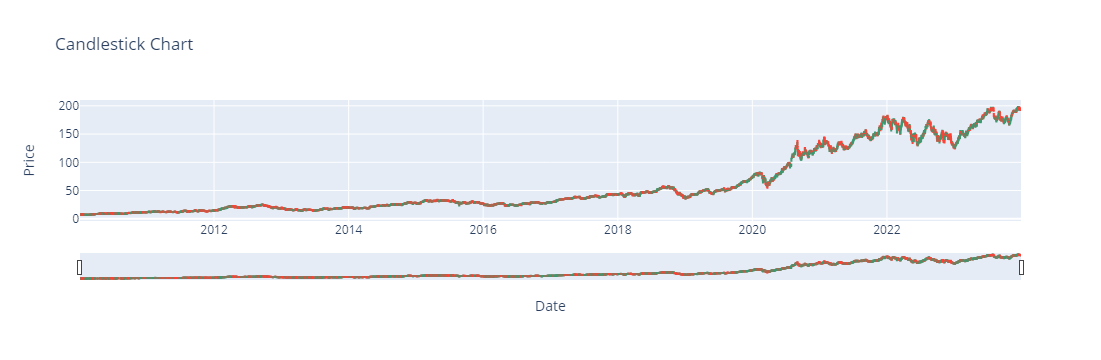

In [81]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(title='Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

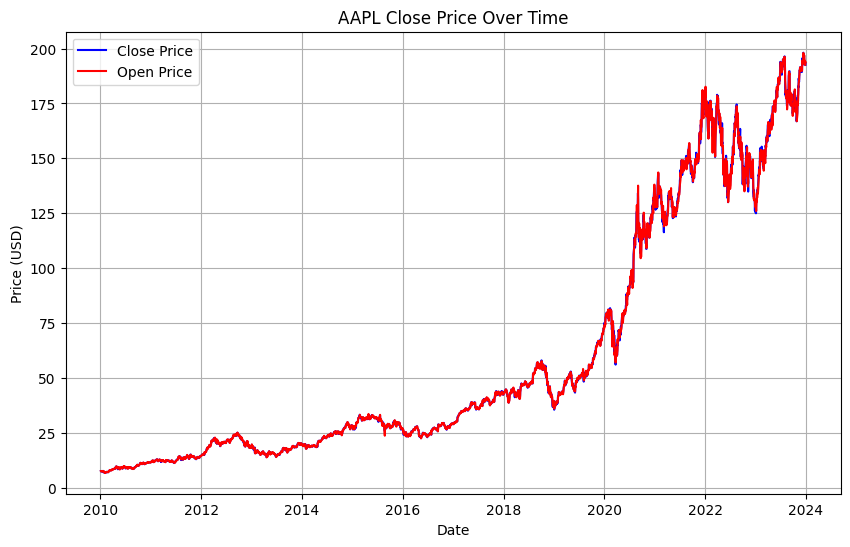

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['Open'], label='Open Price', color='red')

plt.title(f'{ticker_symbol} Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [83]:


# Define training parameters
window_size = 90
initial_balance = 10000
num_episodes = 1000
epsilon = 0.1
alpha = 0.2
gamma = 0.9

# Create environment and agent
actions = [0, 1, 2]  # 0: hold, 1: buy, 2: sell
env = Environment(data, window_size, initial_balance)
agent = QLearningAgent(actions, epsilon, alpha, gamma)



In [59]:
# Training loop
episode_rewards = [] 
episode_losses = [] 
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    agent.losses = []
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        episode_reward += reward
        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        
    episode_rewards.append(episode_reward)
    episode_losses.append(np.mean(agent.losses))
    print(f"Episode: {episode+1} | Total Reward: {episode_reward} | Loss: {np.mean(agent.losses)}")


Episode: 1 | Total Reward: 50.15200930229674 | Loss: 0.003418307366295461
Episode: 2 | Total Reward: 30.970465977566448 | Loss: 0.000959704859030331
Episode: 3 | Total Reward: 31.488020741188958 | Loss: 0.002276482092342012
Episode: 4 | Total Reward: 30.453450020406077 | Loss: 0.0019863747396889246
Episode: 5 | Total Reward: 45.11326188081116 | Loss: 0.0013297256111010998
Episode: 6 | Total Reward: 64.59246843161485 | Loss: 0.002332710101676488
Episode: 7 | Total Reward: 60.89217384078519 | Loss: 0.002901226479521001
Episode: 8 | Total Reward: 35.97657225718305 | Loss: 0.003097543300193187
Episode: 9 | Total Reward: 28.649832968384572 | Loss: 0.0013740060961474128
Episode: 10 | Total Reward: 9.153017796116346 | Loss: 0.001171152926941493


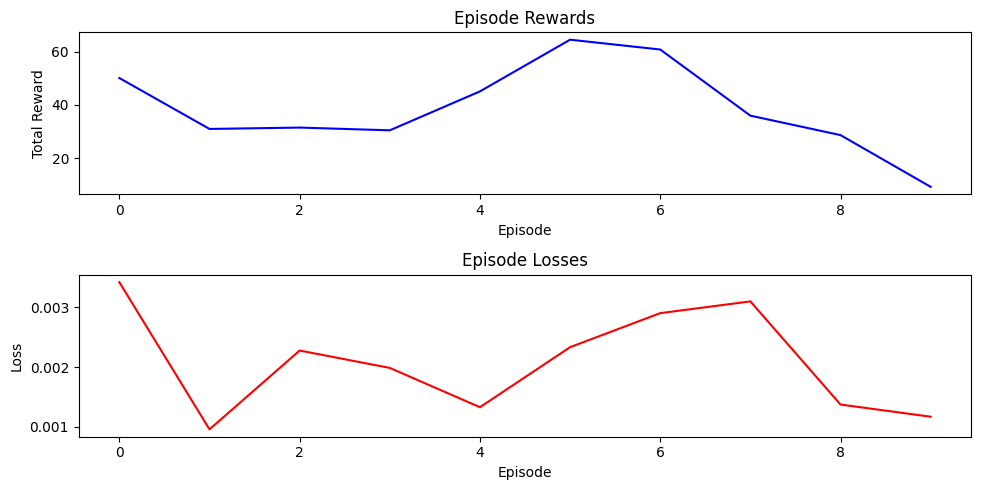

In [61]:
import matplotlib.pyplot as plt

# Plotting episode rewards
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(range(len(episode_rewards)), episode_rewards, color='blue')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plotting episode losses
plt.subplot(2, 1, 2)
plt.plot(range(len(episode_losses)), episode_losses, color='red')
plt.title('Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
